In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
import polars as pl
from datetime import time

sns.set_style("whitegrid", rc = {"grid.color": ".6", "grid.linestyle": "--"})

import matplotlib.pyplot as plt
plt.rcParams['lines.linestyle'] = '--'

import warnings
warnings.filterwarnings('ignore')

# read events data

In [31]:

schema = {'series_id':'string',
         'night':'uint16',
         'event':'string',
         'step':'float32'
         }
events_data = pd.read_csv('../train_events.csv',dtype = schema)

events_data = events_data.dropna()

events_data['timestamp'] = pd.to_datetime(events_data['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce',utc=False)

In [35]:
events_data['timestamp'] = events_data['timestamp'].astype(str).str[:-6]

In [37]:
events_data['timestamp'] = pd.to_datetime(events_data['timestamp'], errors='coerce')

In [38]:
events_data['time'] = events_data['timestamp'].dt.time

In [58]:
onset_times = events_data[(events_data['event'] == 'onset') & (events_data['time'] > time(10, 0))]['time']
wakeup_times = events_data[events_data['event'] == 'wakeup']['time']
earliest_night_start = onset_times.min()
latest_night_end = wakeup_times.max()
print(f"Earliest night start: {earliest_night_start}")
print(f"Latest night end: {latest_night_end}")

Earliest night start: 11:26:00
Latest night end: 20:30:00


In [4]:
series_data = pd.read_parquet('../train_series.parquet')

In [5]:
series_data

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [6]:
# null_series_id= events_data.groupby('series_id').agg({'step': lambda x : (x.isnull().sum() / (len(x)) *100)
#                                      }).reset_index()
# null_series_id = null_series_id[null_series_id['step']<=75]['series_id'].to_list()
# df4 = pd.merge(series_data[series_data.series_id.isin(null_series_id)],events_data[['series_id','step','event']],on = ['series_id','step'],how='left')
# df4.to_parquet('merged75.parquet')
# df4

In [7]:
print('Number of unique users/ accelerometer in event data :',  events_data.series_id.nunique())

Number of unique users/ accelerometer in event data : 277


In [8]:
# only 37 series of events data have non null rows   
events_data.groupby('series_id')['step'].apply(lambda x:x.isnull().any()).value_counts()

True     240
False     37
Name: step, dtype: int64

> ## Not all events for each series are null. we need to find out % of missing rows for each series and then keep/drop them accordingly 

In [9]:
null_series_id= events_data.groupby('series_id').agg({'step': lambda x : (x.isnull().sum() / (len(x)) *100)
                                     }).reset_index()

print('Number of series which have 0% null rows are : ',len(null_series_id[null_series_id['step']==0]))
print('Number of series which have LT 25% null rows : ',len(null_series_id[null_series_id['step']<=25]))

Number of series which have 0% null rows are :  37
Number of series which have LT 25% null rows :  156


In [10]:
null_series_id

,series_id,step
0,038441c925bb,17.391304
1,03d92c9f6f8a,78.378378
2,0402a003dae9,25.000000
3,04f547b8017d,43.243243
4,05e1944c3818,12.500000
...,...,...
272,fa149c3c4bde,33.333333
273,fb223ed2278c,90.566038
274,fbf33b1a2c10,16.666667
275,fcca183903b7,2.777778


> ### I will have to find a way to fill these 156 series which have less than 25 % null rows. I will do it later 

In [11]:
null_series_id = null_series_id[null_series_id['step']==0]['series_id'].to_list()

In [12]:
# taking events which have atmost 25% null rows
events_data = events_data[events_data['series_id'].isin(null_series_id)]

In [13]:
# Function to label nights as weekend or weekday
def is_weekend(row):
    if pd.notnull(row['timestamp']):  # Check if timestamp is not NaT
        onset_day = row['timestamp'].weekday()  # 0 for Monday, 6 for Sunday
        if row['event'] == 'onset' and (onset_day == 4 or onset_day == 5):  # If it's a Friday or Saturday, then it's a weekend
            return 1
    return 0

events_data['is_weekend'] = events_data.apply(is_weekend, axis=1)
events_data['is_weekend'] = events_data['is_weekend'].astype('uint8')

In [14]:
# Forward-fill the 'is_weekend' column for 'wakeup' events on the same night
events_data['is_weekend'] = events_data.groupby(['series_id', 'night'])['is_weekend'].transform('max')

In [15]:
events_data

,series_id,night,event,step,timestamp,is_weekend
398,08db4255286f,1,onset,11988.0,2018-11-06 06:39:00+00:00,0
399,08db4255286f,1,wakeup,14388.0,2018-11-06 09:59:00+00:00,0
400,08db4255286f,2,onset,28680.0,2018-11-07 05:50:00+00:00,0
401,08db4255286f,2,wakeup,31320.0,2018-11-07 09:30:00+00:00,0
402,08db4255286f,3,onset,44184.0,2018-11-08 03:22:00+00:00,0
...,...,...,...,...,...,...
11673,d5e47b94477e,21,wakeup,356172.0,2017-11-30 13:41:00+00:00,0
11674,d5e47b94477e,22,onset,366756.0,2017-12-01 04:23:00+00:00,1
11675,d5e47b94477e,22,wakeup,373176.0,2017-12-01 13:18:00+00:00,1
11676,d5e47b94477e,23,onset,383616.0,2017-12-02 03:48:00+00:00,1


In [16]:
# each step is 5 min ( checked from series_data ) , so converting to hours 
events_data['sleep_duration'] = (( events_data.groupby(['series_id','night'])['step'].diff()*5 ) /3600)#.fillna(0)

events_data['sleep_duration'] = events_data.groupby(['series_id', 'night'])['sleep_duration'].transform('max')

In [17]:
events_data

,series_id,night,event,step,timestamp,is_weekend,sleep_duration
398,08db4255286f,1,onset,11988.0,2018-11-06 06:39:00+00:00,0,3.333333
399,08db4255286f,1,wakeup,14388.0,2018-11-06 09:59:00+00:00,0,3.333333
400,08db4255286f,2,onset,28680.0,2018-11-07 05:50:00+00:00,0,3.666667
401,08db4255286f,2,wakeup,31320.0,2018-11-07 09:30:00+00:00,0,3.666667
402,08db4255286f,3,onset,44184.0,2018-11-08 03:22:00+00:00,0,6.866667
...,...,...,...,...,...,...,...
11673,d5e47b94477e,21,wakeup,356172.0,2017-11-30 13:41:00+00:00,0,10.083333
11674,d5e47b94477e,22,onset,366756.0,2017-12-01 04:23:00+00:00,1,8.916667
11675,d5e47b94477e,22,wakeup,373176.0,2017-12-01 13:18:00+00:00,1,8.916667
11676,d5e47b94477e,23,onset,383616.0,2017-12-02 03:48:00+00:00,1,9.000000


## Average sleep time

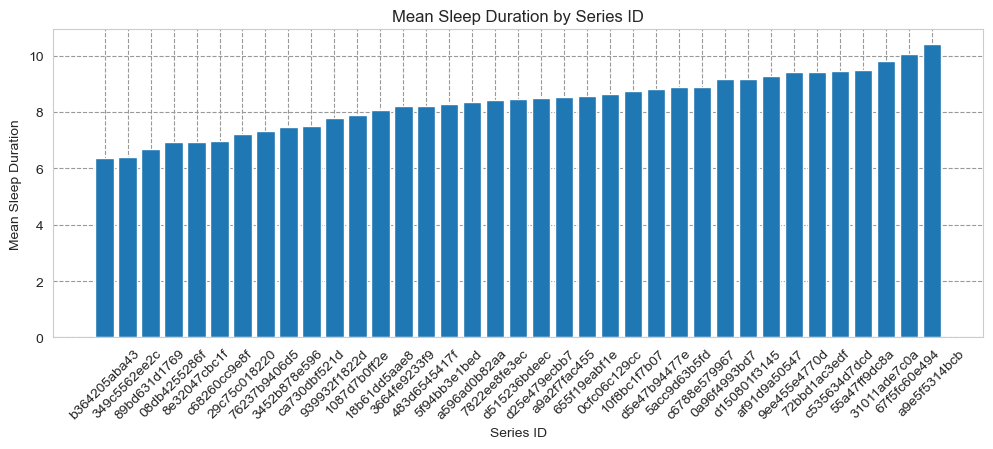

In [18]:
mean_sleep_duration = events_data.dropna().groupby(['series_id'])['sleep_duration'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 4))
plt.bar(mean_sleep_duration['series_id'], mean_sleep_duration['sleep_duration'])
plt.xlabel('Series ID')
plt.ylabel('Mean Sleep Duration')
plt.title('Mean Sleep Duration by Series ID')
plt.xticks(rotation=45) 
plt.show()

## do users sleep more on average on weekends ? 

<Axes: xlabel='is_weekend', ylabel='sleep_duration'>

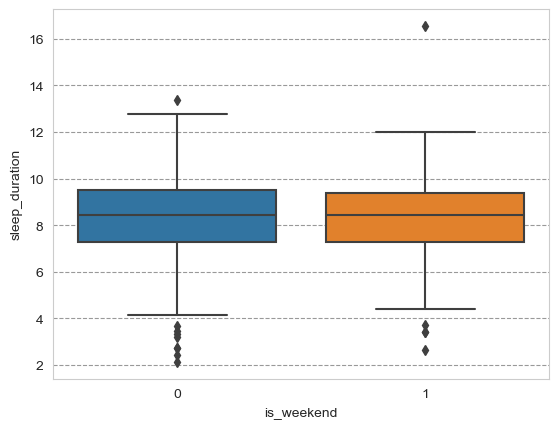

In [19]:
sns.boxplot(data= events_data[events_data['event']=='wakeup'],x='is_weekend',y='sleep_duration')

In [20]:
weekend_sleep = events_data[(events_data['is_weekend'] == 1) & (events_data['event']=='wakeup') ]['sleep_duration'].fillna(0)
weekday_sleep = events_data[(events_data['is_weekend'] == 0) & (events_data['event']=='wakeup')]['sleep_duration'].fillna(0)

# t-test
t_stat, p_value = stats.ttest_ind(weekend_sleep, weekday_sleep)

# significance level
alpha = 0.05

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print('Reject the null hypothesis: People sleep significantly more on weekends.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in sleep duration between weekends and weekdays.')


T-statistic: 0.535649573408188
P-value: 0.5923536515790895
Fail to reject the null hypothesis: There is no significant difference in sleep duration between weekends and weekdays.


## How many DAYTIME sleep cycles are present ?

In [21]:
events_data['hour'] = pd.to_datetime(events_data['timestamp']).dt.hour

events_data['is_daytime_sleeping'] = 'night'
events_data.loc[(events_data['hour']<7) &  (events_data['event']=='onset'),'is_daytime_sleeping'] = 'day'

In [22]:
events_data

,series_id,night,event,step,timestamp,is_weekend,sleep_duration,hour,is_daytime_sleeping
398,08db4255286f,1,onset,11988.0,2018-11-06 06:39:00+00:00,0,3.333333,6,day
399,08db4255286f,1,wakeup,14388.0,2018-11-06 09:59:00+00:00,0,3.333333,9,night
400,08db4255286f,2,onset,28680.0,2018-11-07 05:50:00+00:00,0,3.666667,5,day
401,08db4255286f,2,wakeup,31320.0,2018-11-07 09:30:00+00:00,0,3.666667,9,night
402,08db4255286f,3,onset,44184.0,2018-11-08 03:22:00+00:00,0,6.866667,3,day
...,...,...,...,...,...,...,...,...,...
11673,d5e47b94477e,21,wakeup,356172.0,2017-11-30 13:41:00+00:00,0,10.083333,13,night
11674,d5e47b94477e,22,onset,366756.0,2017-12-01 04:23:00+00:00,1,8.916667,4,day
11675,d5e47b94477e,22,wakeup,373176.0,2017-12-01 13:18:00+00:00,1,8.916667,13,night
11676,d5e47b94477e,23,onset,383616.0,2017-12-02 03:48:00+00:00,1,9.000000,3,day


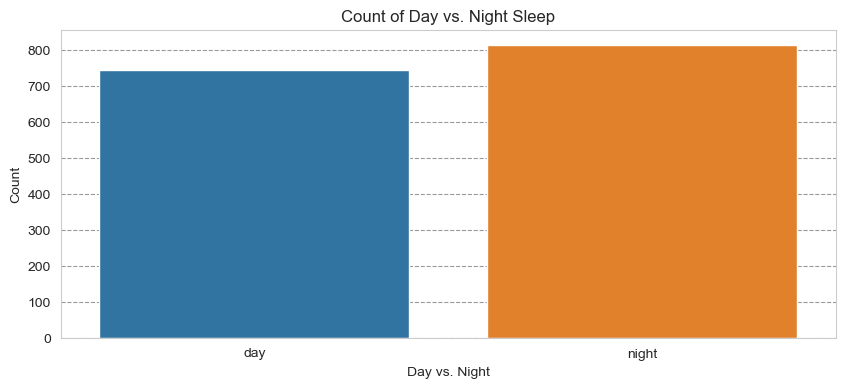

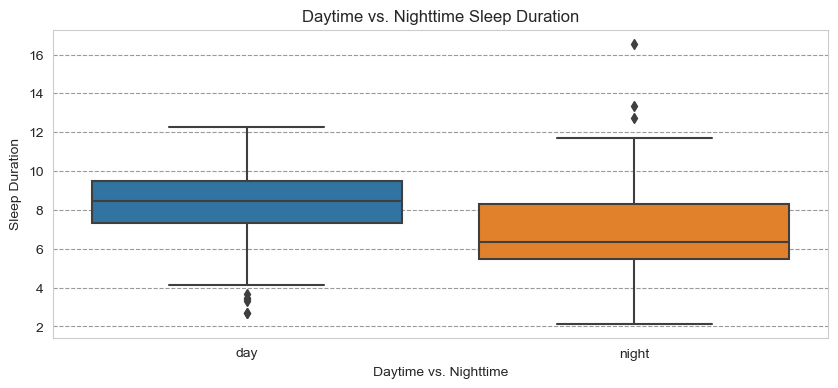

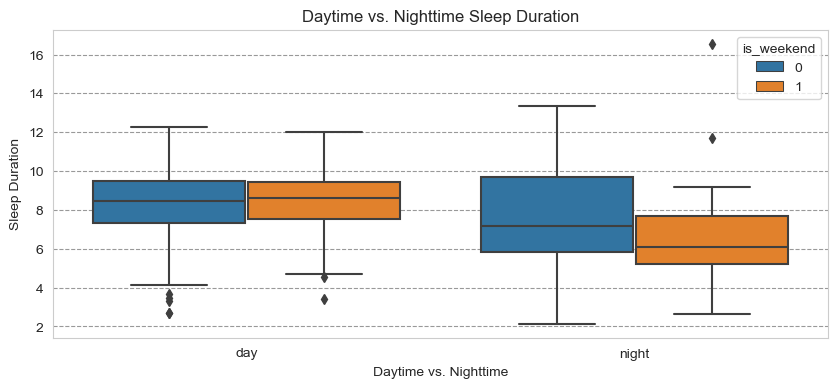

In [23]:
# Create a count plot for day vs. night
plt.figure(figsize=(10, 4))
sns.countplot(data=events_data, x='is_daytime_sleeping')
plt.title('Count of Day vs. Night Sleep')
plt.xlabel('Day vs. Night')
plt.ylabel('Count')

# Create a box plot for daytime vs. nighttime sleep duration
plt.figure(figsize=(10, 4))
sns.boxplot(data=events_data[events_data['event'] == 'onset'], x='is_daytime_sleeping', y='sleep_duration')
plt.title('Daytime vs. Nighttime Sleep Duration')
plt.xlabel('Daytime vs. Nighttime')
plt.ylabel('Sleep Duration')

# Create a box plot for daytime vs. nighttime sleep duration
plt.figure(figsize=(10, 4))
sns.boxplot(data=events_data[events_data['event'] == 'onset'], x='is_daytime_sleeping', y='sleep_duration', hue='is_weekend')
plt.title('Daytime vs. Nighttime Sleep Duration')
plt.xlabel('Daytime vs. Nighttime')
plt.ylabel('Sleep Duration')

plt.show()



> ## user sleeping less on average if it's a weekend night 

## series data

In [24]:
# for replacing seriesId with a uniqueID 
# series_id_map = {value: series_id for series_id,value in enumerate(events_data['series_id'].unique())}

# events_data['series_id'] = events_data['series_id'].map(series_id_map)

In [25]:
schema = pa.schema([('series_id',pa.string()),
          ('step',pa.int32()),
          # ('timestamp',pa.timestamp('ms',tz='UTC')),
          ('timestamp',pa.string()),
          ('anglez',pa.float32()),
          ('enmo',pa.float32())
         ])
series_data = pq.read_table('../train_series.parquet',schema=schema)

series_data = series_data.to_pandas()

In [26]:
series_data = pq.read_table('../train_series.parquet')

In [27]:
series_data = series_data.to_pandas()

In [28]:
series_data['timestamp']

0            2018-08-14T15:30:00-0400
1            2018-08-14T15:30:05-0400
2            2018-08-14T15:30:10-0400
3            2018-08-14T15:30:15-0400
4            2018-08-14T15:30:20-0400
                       ...           
127946335    2017-09-08T00:14:35-0400
127946336    2017-09-08T00:14:40-0400
127946337    2017-09-08T00:14:45-0400
127946338    2017-09-08T00:14:50-0400
127946339    2017-09-08T00:14:55-0400
Name: timestamp, Length: 127946340, dtype: object

In [29]:
# %%time
# series data should have same cases as events data 
# series_data = series_data[series_data['series_id'].isin(series_id_map.keys())]
series_data = series_data[series_data['series_id'].isin(events_data['series_id'].unique())]
# # map series_id with unique ID 
# series_data['series_id'] = series_data['series_id'].map(series_id_map)
# # space saving 
# series_data['series_id'] = series_data['series_id'].astype('int16')

In [30]:
print('Number of unique users/ accelerometer in series data  :',  series_data.series_id.nunique())
print('Number of unique users/ accelerometer in event data :',  events_data.series_id.nunique())

Number of unique users/ accelerometer in series data  : 37
Number of unique users/ accelerometer in event data : 37


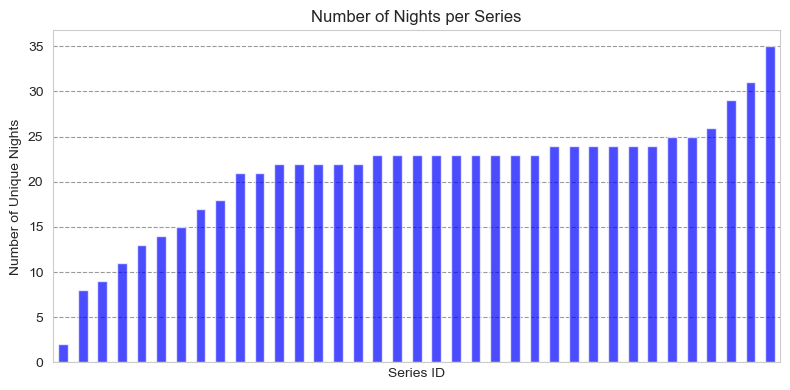

In [31]:
unique_nights_per_series = events_data.groupby('series_id')['night'].nunique().sort_values()

# Create a bar plot
plt.figure(figsize=(8, 4))
unique_nights_per_series.plot(kind='bar', color='blue', alpha=0.7)
plt.xticks([])
plt.xlabel('Series ID')
plt.ylabel('Number of Unique Nights')
plt.title('Number of Nights per Series')
plt.grid(True)  # Add grid lines for the y-axis
plt.tight_layout()
plt.show()


# Merge and clean

In [32]:
df = pd.merge(series_data,events_data[['series_id','step','event']],on = ['series_id','step'],how='left')

> ## I am assuming user sleeps between oneset and wakeup , so all the rows in between are sleep data

# dropping extra onset

In [33]:
# check if all series have equal wakeup and onset :

# for i in df['series_id'].unique():
#     temp = pd.DataFrame(df[df['series_id']==i]['event'].value_counts()).reset_index()
#     if temp['count'].nunique() != 1:
#         print('series_id : ',i)
#         display(temp)

In [34]:
# checking which index has extra onset
df[(df['event'].isin(['wakeup','onset'])) & (df['series_id']=="c6788e579967") ]['event'].value_counts()

onset     23
wakeup    23
Name: event, dtype: Int64

> drop index = **'5918484'**

In [35]:
# checking which index has extra onset

df[(df['event'].isin(['wakeup','onset'])) & (df['series_id']=="655f19eabf1e") ]['event'].value_counts()

onset     22
wakeup    22
Name: event, dtype: Int64

> drop index = **'12168012'**

In [36]:
# dropping extra onset 

# df.drop(5918484,inplace=True)
# df.drop(12168012,inplace=True)

In [37]:
df

,series_id,step,timestamp,anglez,enmo,event
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,<NA>
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,<NA>
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,<NA>
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,<NA>
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,<NA>
...,...,...,...,...,...,...
14334835,d5e47b94477e,395815,2017-12-02T15:44:35-0500,-10.064100,0.1552,<NA>
14334836,d5e47b94477e,395816,2017-12-02T15:44:40-0500,-10.006700,0.1139,<NA>
14334837,d5e47b94477e,395817,2017-12-02T15:44:45-0500,-3.328600,0.1245,<NA>
14334838,d5e47b94477e,395818,2017-12-02T15:44:50-0500,-5.903100,0.1363,<NA>


In [38]:
# new column 'is_asleep' 
df['is_asleep'] = 0

group_by_series = df.groupby('series_id')

# For every series_id getting sleeping intervlas 
for _, group_data in group_by_series:
    onset_indices = group_data.index[group_data['event'] == 'onset']
    wakeup_indices = group_data.index[group_data['event'] == 'wakeup']

    cycle_boundaries = list(zip(onset_indices, wakeup_indices))

    for cycle_start, cycle_end in cycle_boundaries:
        df.loc[cycle_start : cycle_end - 1, 'is_asleep'] = 1

In [39]:
df['is_asleep'].value_counts()

0    9674352
1    4660488
Name: is_asleep, dtype: int64

In [40]:
df

,series_id,step,timestamp,anglez,enmo,event,is_asleep
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,<NA>,0
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,<NA>,0
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,<NA>,0
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,<NA>,0
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,<NA>,0
...,...,...,...,...,...,...,...
14334835,d5e47b94477e,395815,2017-12-02T15:44:35-0500,-10.064100,0.1552,<NA>,0
14334836,d5e47b94477e,395816,2017-12-02T15:44:40-0500,-10.006700,0.1139,<NA>,0
14334837,d5e47b94477e,395817,2017-12-02T15:44:45-0500,-3.328600,0.1245,<NA>,0
14334838,d5e47b94477e,395818,2017-12-02T15:44:50-0500,-5.903100,0.1363,<NA>,0


In [41]:
# df.to_parquet('merged.parquet')

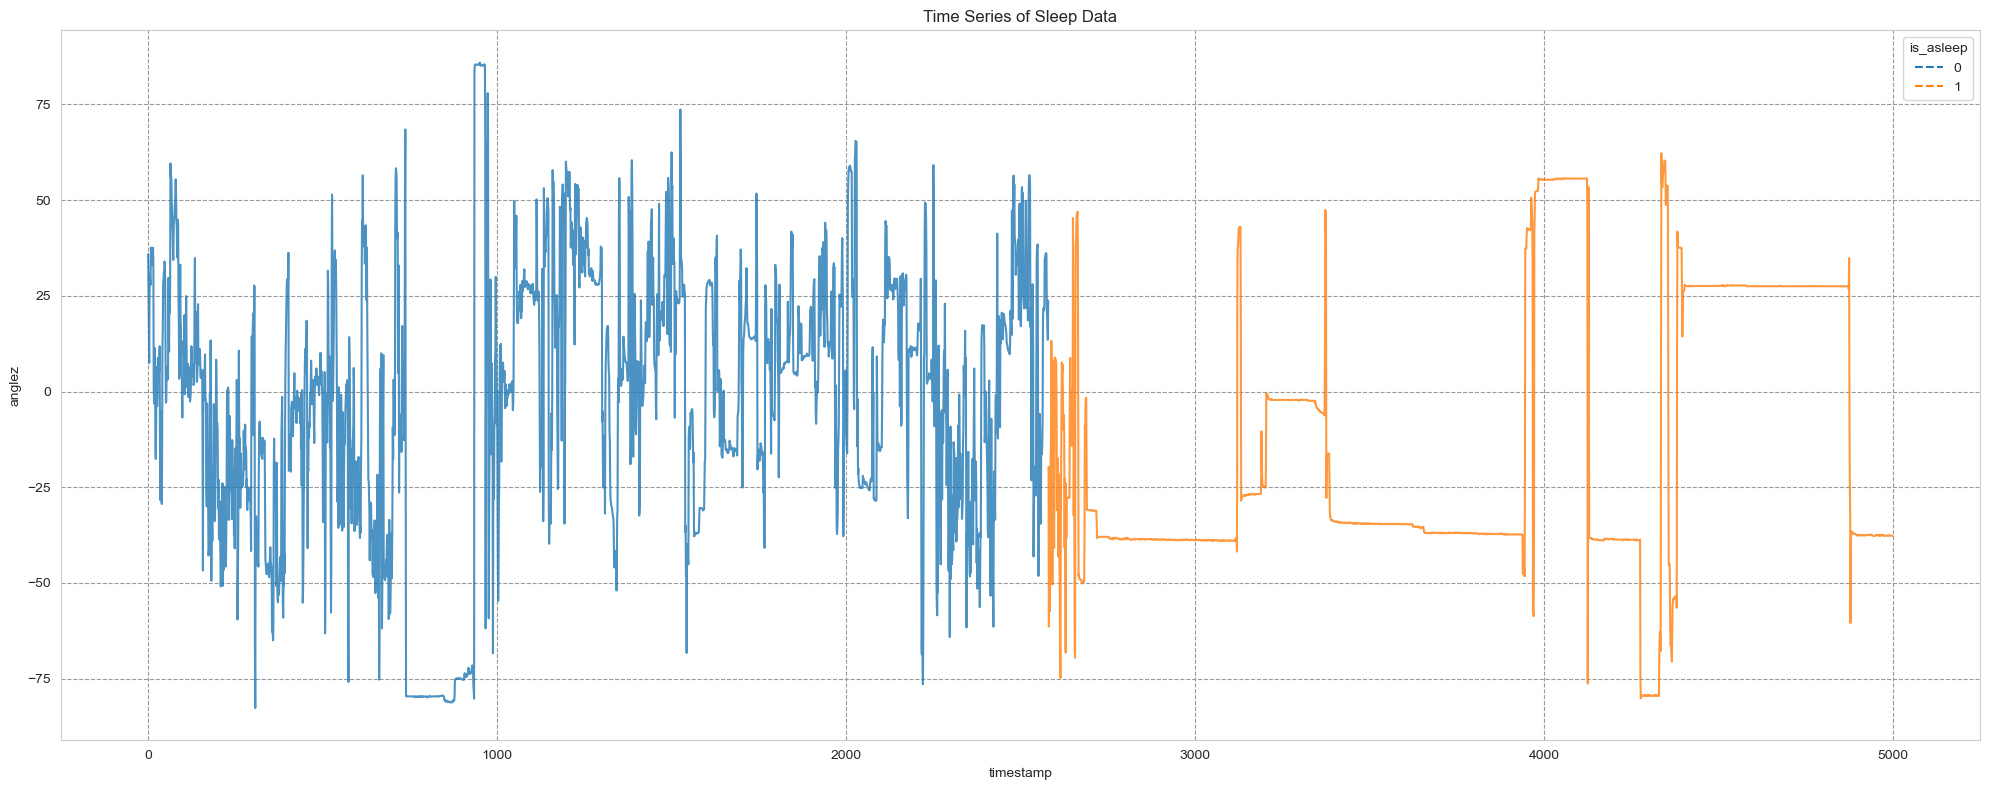

In [42]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the sleep data
sns.lineplot(data = df[df['series_id']=="c6788e579967"][:5000] ,x='step', y = 'anglez',hue='is_asleep', alpha=0.8)
ax.set_xlabel('timestamp')
ax.set_ylabel('anglez')
ax.set_title('Time Series of Sleep Data')

ax.grid(True)
plt.tight_layout()
plt.show()


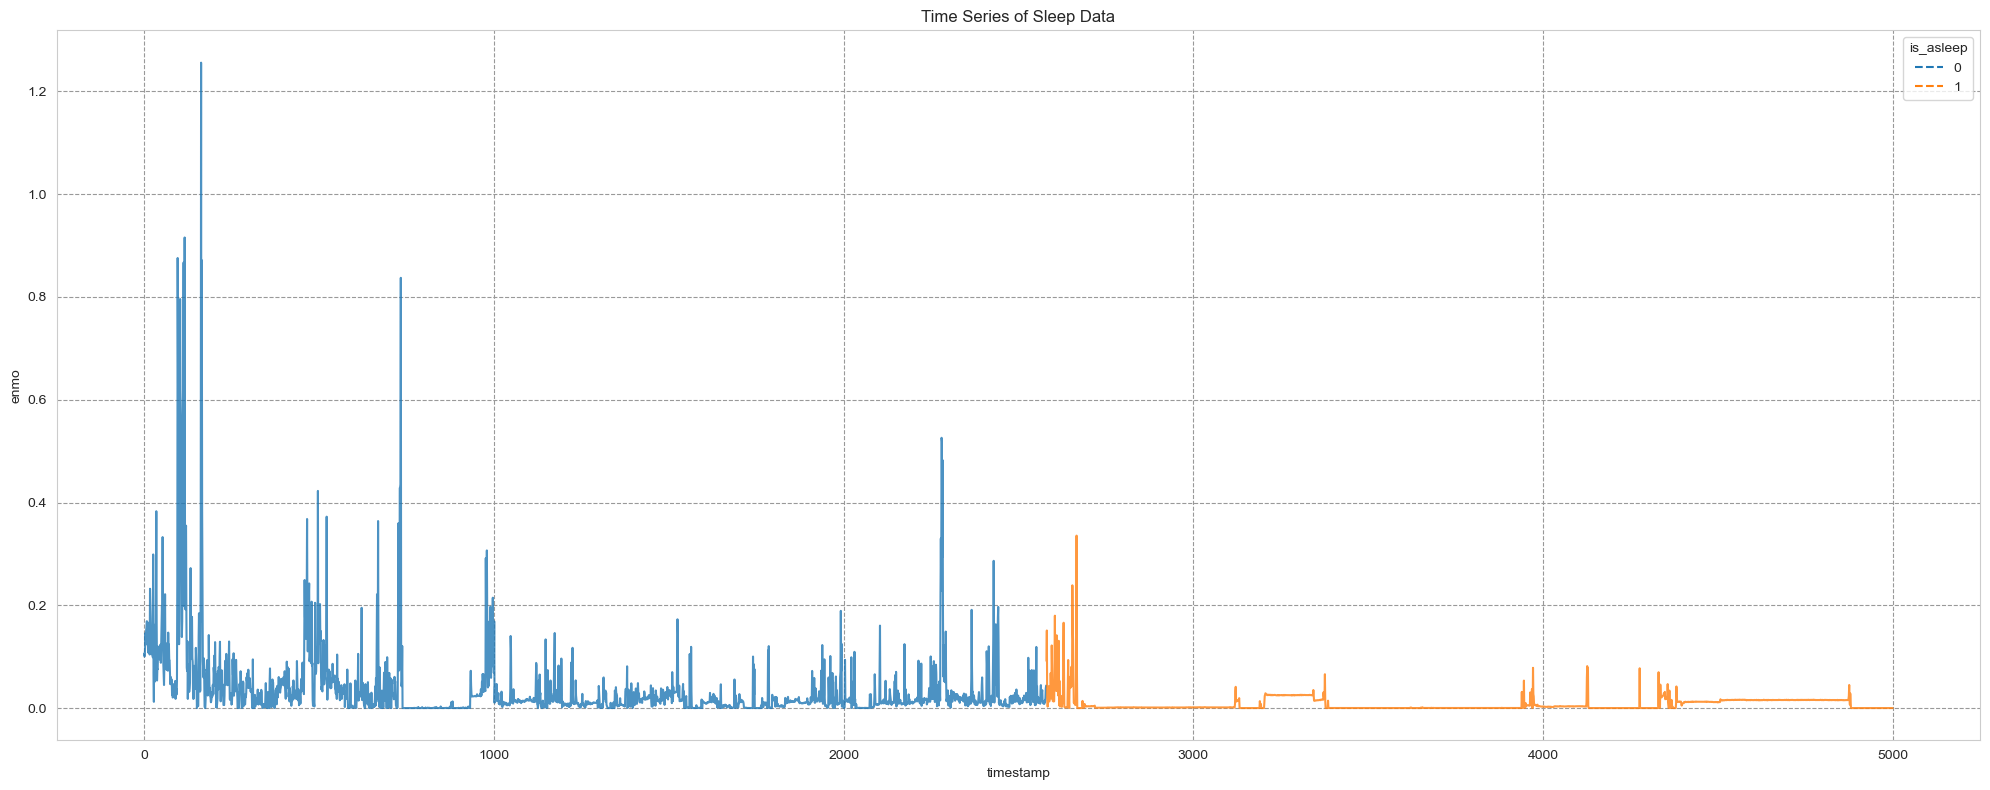

In [43]:
plt.figure(figsize=(20, 8))
sns.lineplot(data = df[df['series_id']=="c6788e579967"][:5000] ,x='step', y = 'enmo',hue='is_asleep', alpha=0.8)
plt.xlabel('timestamp')
plt.ylabel('enmo')
plt.title('Time Series of Sleep Data')

plt.grid(True)
plt.tight_layout()
plt.show()

---

# Full Data

In [44]:
%%time
schema = pa.schema([('series_id',pa.string()),
          ('step',pa.int32()),
          ('timestamp',pa.timestamp('ms',tz='UTC')),
          ('anglez',pa.float32()),
          ('enmo',pa.float32())
         ])
series_data = pq.read_table('../train_series.parquet',schema=schema)

series_data = series_data.to_pandas()

CPU times: total: 8.92 s
Wall time: 20.3 s


In [45]:
series_data['series_id'].unique()

array(['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d',
       '05e1944c3818', '062cae666e2a', '062dbd4c95e6', '08db4255286f',
       '0a96f4993bd7', '0cd1e3d0ed95', '0ce74d6d2106', '0cfc06c129cc',
       '0d0ad1e77851', '0dee4fda51c3', '0ec9fc461819', '0ef7d94fde99',
       '0f572d690310', '0f9e60a8e56d', '10469f6765bf', '1087d7b0ff2e',
       '10f8bc1f7b07', '12d01911d509', '1319a1935f48', '137771d19ca2',
       '137b99e936ab', '13b4d6a01d27', '148471991ffb', '154fe824ed87',
       '16fe2798ed0f', '1716cd4163b2', '1762ab70ec76', '188d4b7cd28b',
       '18a0ca03431d', '18b61dd5aae8', '1955d568d987', '1b92be89db4c',
       '1c7c0bad1263', '1d4569cbac0f', '1e6717d93c1d', '1f96b9668bdf',
       '207eded97727', '25e2b3dd9c3b', '2654a87be968', '27f09a6a858f',
       '280e08693c6d', '292a75c0b94e', '29c75c018220', '29d3469bd15d',
       '2b0a1fa8eba8', '2b8d87addea9', '2cd2340ca14d', '2e9ced2c7976',
       '2f7504d0f426', '2fbbee1a38e3', '2fc653ca75c7', '31011ade7c0a',
      

In [46]:
schema = {'series_id':'string',
         'night':'uint16',
         'event':'string',
         'step':'float32'
         }
events_data = pd.read_csv('../train_events.csv',dtype = schema)

events_data['timestamp'] =pd.to_datetime(events_data['timestamp'],utc=True,errors='coerce')

In [47]:
print('Number of unique users/ accelerometer in series data  :',  series_data.series_id.nunique())
print('Number of unique users/ accelerometer in event data :',  events_data.series_id.nunique())

Number of unique users/ accelerometer in series data  : 277
Number of unique users/ accelerometer in event data : 277


In [48]:
df2 = pd.merge(series_data,events_data[['series_id','step','event']],on = ['series_id','step'],how='left')

In [49]:
# new column 'is_asleep' 
df2['is_asleep'] = 0

group_by_series = df2.groupby('series_id')

# For every series_id getting sleeping intervlas 
for _, group_data in group_by_series:
    onset_indices = group_data.index[group_data['event'] == 'onset']
    wakeup_indices = group_data.index[group_data['event'] == 'wakeup']

    cycle_boundaries = list(zip(onset_indices, wakeup_indices))

    for cycle_start, cycle_end in cycle_boundaries:
        df2.loc[cycle_start : cycle_end - 1, 'is_asleep'] = 1

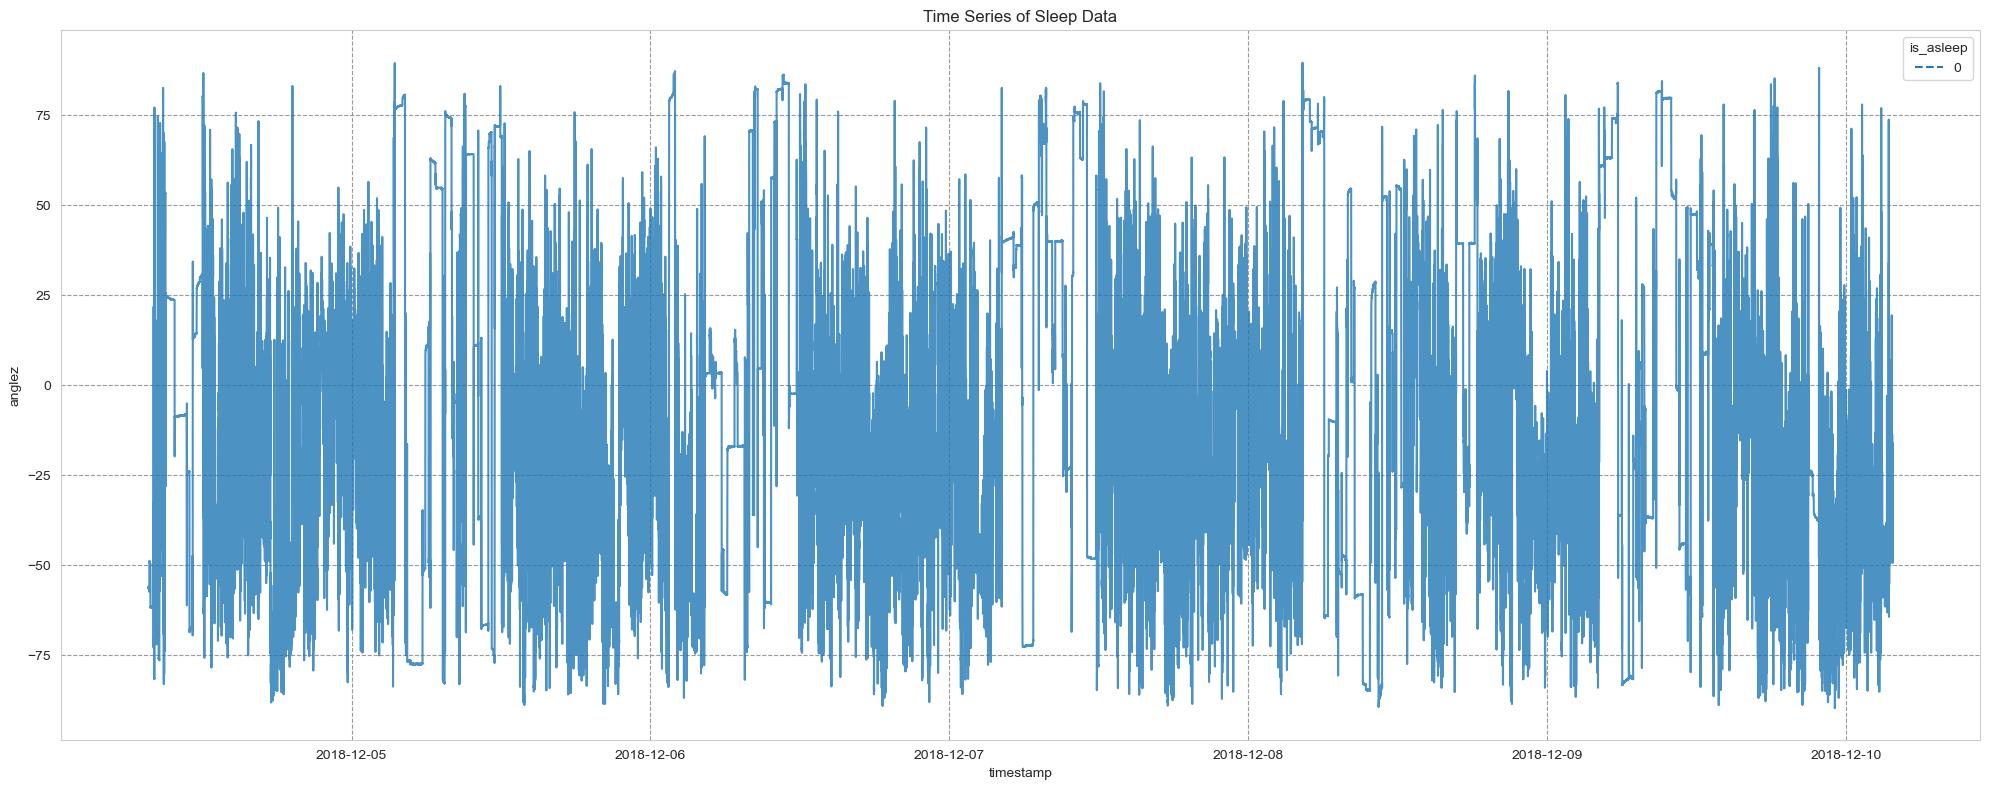

In [52]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the sleep data
sns.lineplot(data = df2[df2['series_id']=="05e1944c3818"].reset_index()[300000:] ,x='timestamp', y = 'anglez',hue='is_asleep', alpha=0.8)
ax.set_xlabel('timestamp')
ax.set_ylabel('anglez')
ax.set_title('Time Series of Sleep Data')

ax.grid(True)
plt.tight_layout()
plt.show()

In [46]:
df2

,series_id,step,timestamp,anglez,enmo,event,is_asleep
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,<NA>,0
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,<NA>,0
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,<NA>,0
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,<NA>,0
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,<NA>,0
...,...,...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08 04:14:35+00:00,-27.277500,0.0204,<NA>,0
127946336,fe90110788d2,592376,2017-09-08 04:14:40+00:00,-27.032499,0.0233,<NA>,0
127946337,fe90110788d2,592377,2017-09-08 04:14:45+00:00,-26.841200,0.0202,<NA>,0
127946338,fe90110788d2,592378,2017-09-08 04:14:50+00:00,-26.723900,0.0199,<NA>,0


# Data missing rate < 10% (97 ids)
we've tried 25% and there are 156 ids, but i think 97 with less then 10% is enough.

In [47]:
null_series_id= events_data.groupby('series_id').agg({'step': lambda x : (x.isnull().sum() / (len(x)) *100)
                                     }).reset_index()

In [48]:
null_series_id = null_series_id[null_series_id['step']<=10]['series_id'].to_list()

In [49]:
null_series_id[:10]

['08db4255286f',
 '0a96f4993bd7',
 '0ce74d6d2106',
 '0cfc06c129cc',
 '0ec9fc461819',
 '0ef7d94fde99',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '1319a1935f48',
 '154fe824ed87']

In [50]:
print('Number of series which have LT 25% null rows : ',len(null_series_id))

Number of series which have LT 25% null rows :  97


In [51]:
df3 = pd.merge(series_data[series_data.series_id.isin(null_series_id)],events_data[['series_id','step','event']],on = ['series_id','step'],how='left')

In [52]:
df3.series_id.nunique()

97

In [53]:
# df3.to_parquet('merged25.parquet')

In [54]:
null_series_id= events_data.groupby('series_id').agg({'step': lambda x : (x.isnull().sum() / (len(x)) *100)
                                     }).reset_index()
null_series_id = null_series_id[null_series_id['step']==0]['series_id'].to_list()
df4 = pd.merge(series_data[series_data.series_id.isin(null_series_id)],events_data[['series_id','step','event']],on = ['series_id','step'],how='left')
df4.to_parquet('merged0.parquet')

In [ ]:
null_series_id= events_data.groupby('series_id').agg({'step': lambda x : (x.isnull().sum() / (len(x)) *100)
                                     }).reset_index()
null_series_id = null_series_id[null_series_id['step']<=25]['series_id'].to_list()
df4 = pd.merge(series_data[series_data.series_id.isin(null_series_id)],events_data[['series_id','step','event']],on = ['series_id','step'],how='left')
df4.to_parquet('merged25.parquet')

In [ ]:
null_series_id= events_data.groupby('series_id').agg({'step': lambda x : (x.isnull().sum() / (len(x)) *100)
                                     }).reset_index()
null_series_id = null_series_id[null_series_id['step']<=50]['series_id'].to_list()
df4 = pd.merge(series_data[series_data.series_id.isin(null_series_id)],events_data[['series_id','step','event']],on = ['series_id','step'],how='left')
df4.to_parquet('merged50.parquet')

In [55]:
# new column 'is_asleep' 
df3['is_asleep'] = 0

group_by_series = df3.groupby('series_id')

# For every series_id getting sleeping intervlas 
for _, group_data in group_by_series:
    onset_indices = group_data.index[group_data['event'] == 'onset']
    wakeup_indices = group_data.index[group_data['event'] == 'wakeup']

    cycle_boundaries = list(zip(onset_indices, wakeup_indices))

    for cycle_start, cycle_end in cycle_boundaries:
        df3.loc[cycle_start : cycle_end - 1, 'is_asleep'] = 1

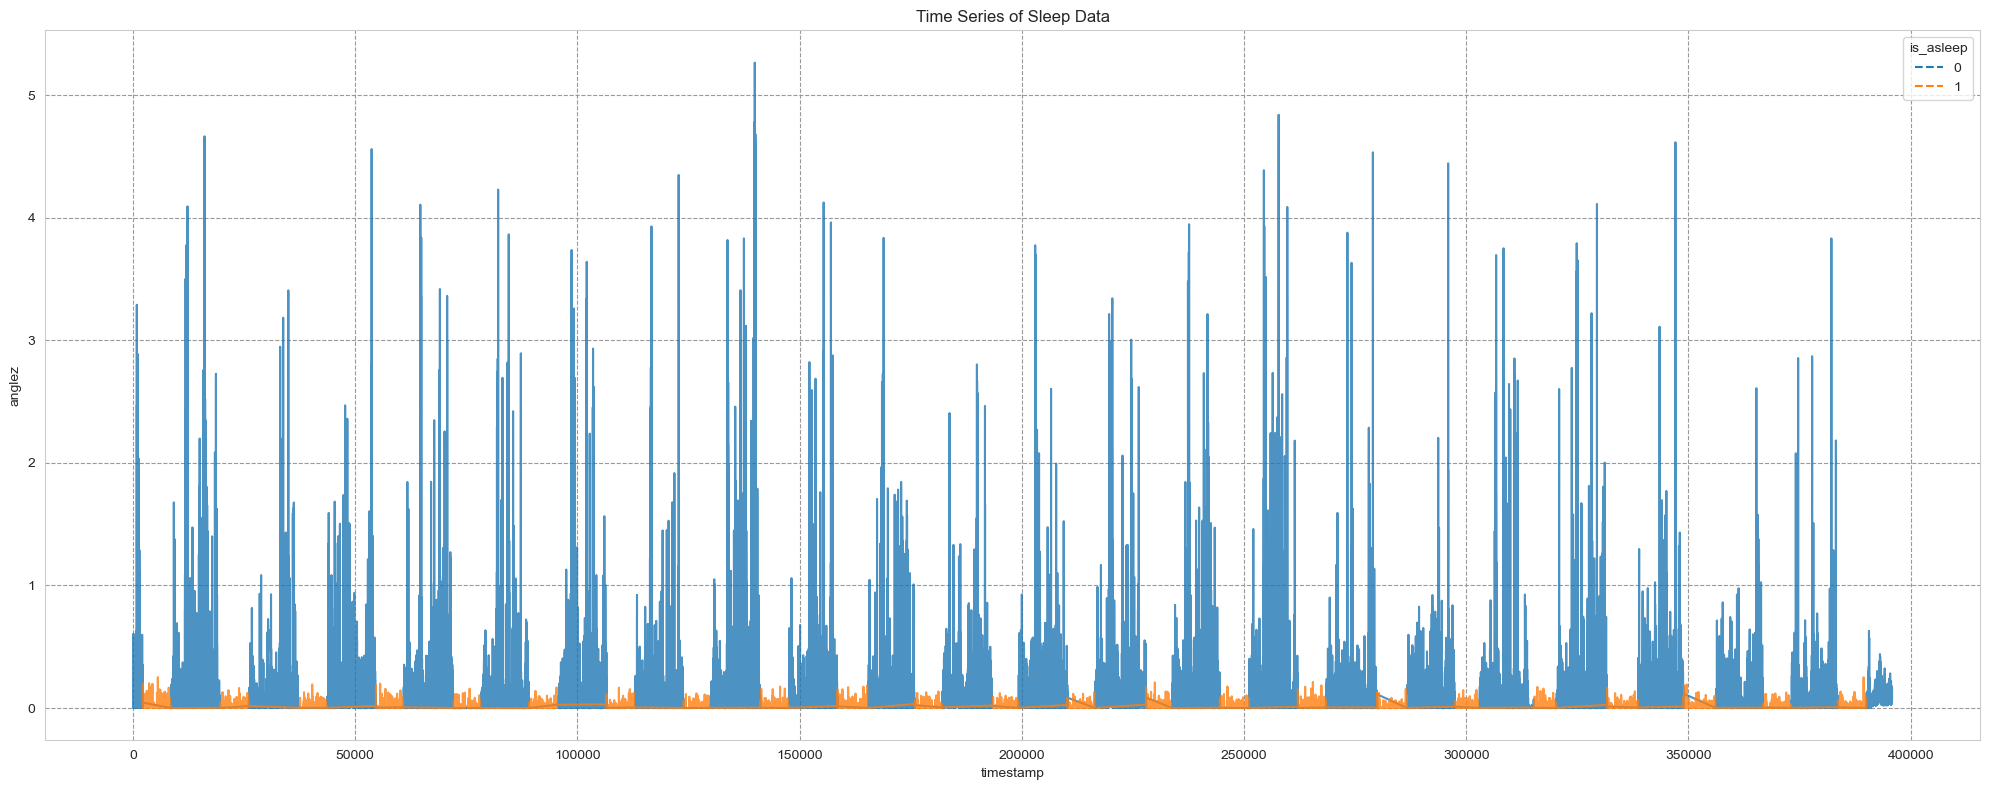

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the sleep data
sns.lineplot(data = df3[df3['series_id']=="d5e47b94477e"] ,x='step', y = 'enmo',hue='is_asleep', alpha=0.8)
ax.set_xlabel('timestamp')
ax.set_ylabel('anglez')
ax.set_title('Time Series of Sleep Data')

ax.grid(True)
plt.tight_layout()
plt.show()

In [63]:
events_data[events_data['series_id'] =="d5e47b94477e"]['event'].value_counts()

onset     23
wakeup    23
Name: event, dtype: Int64

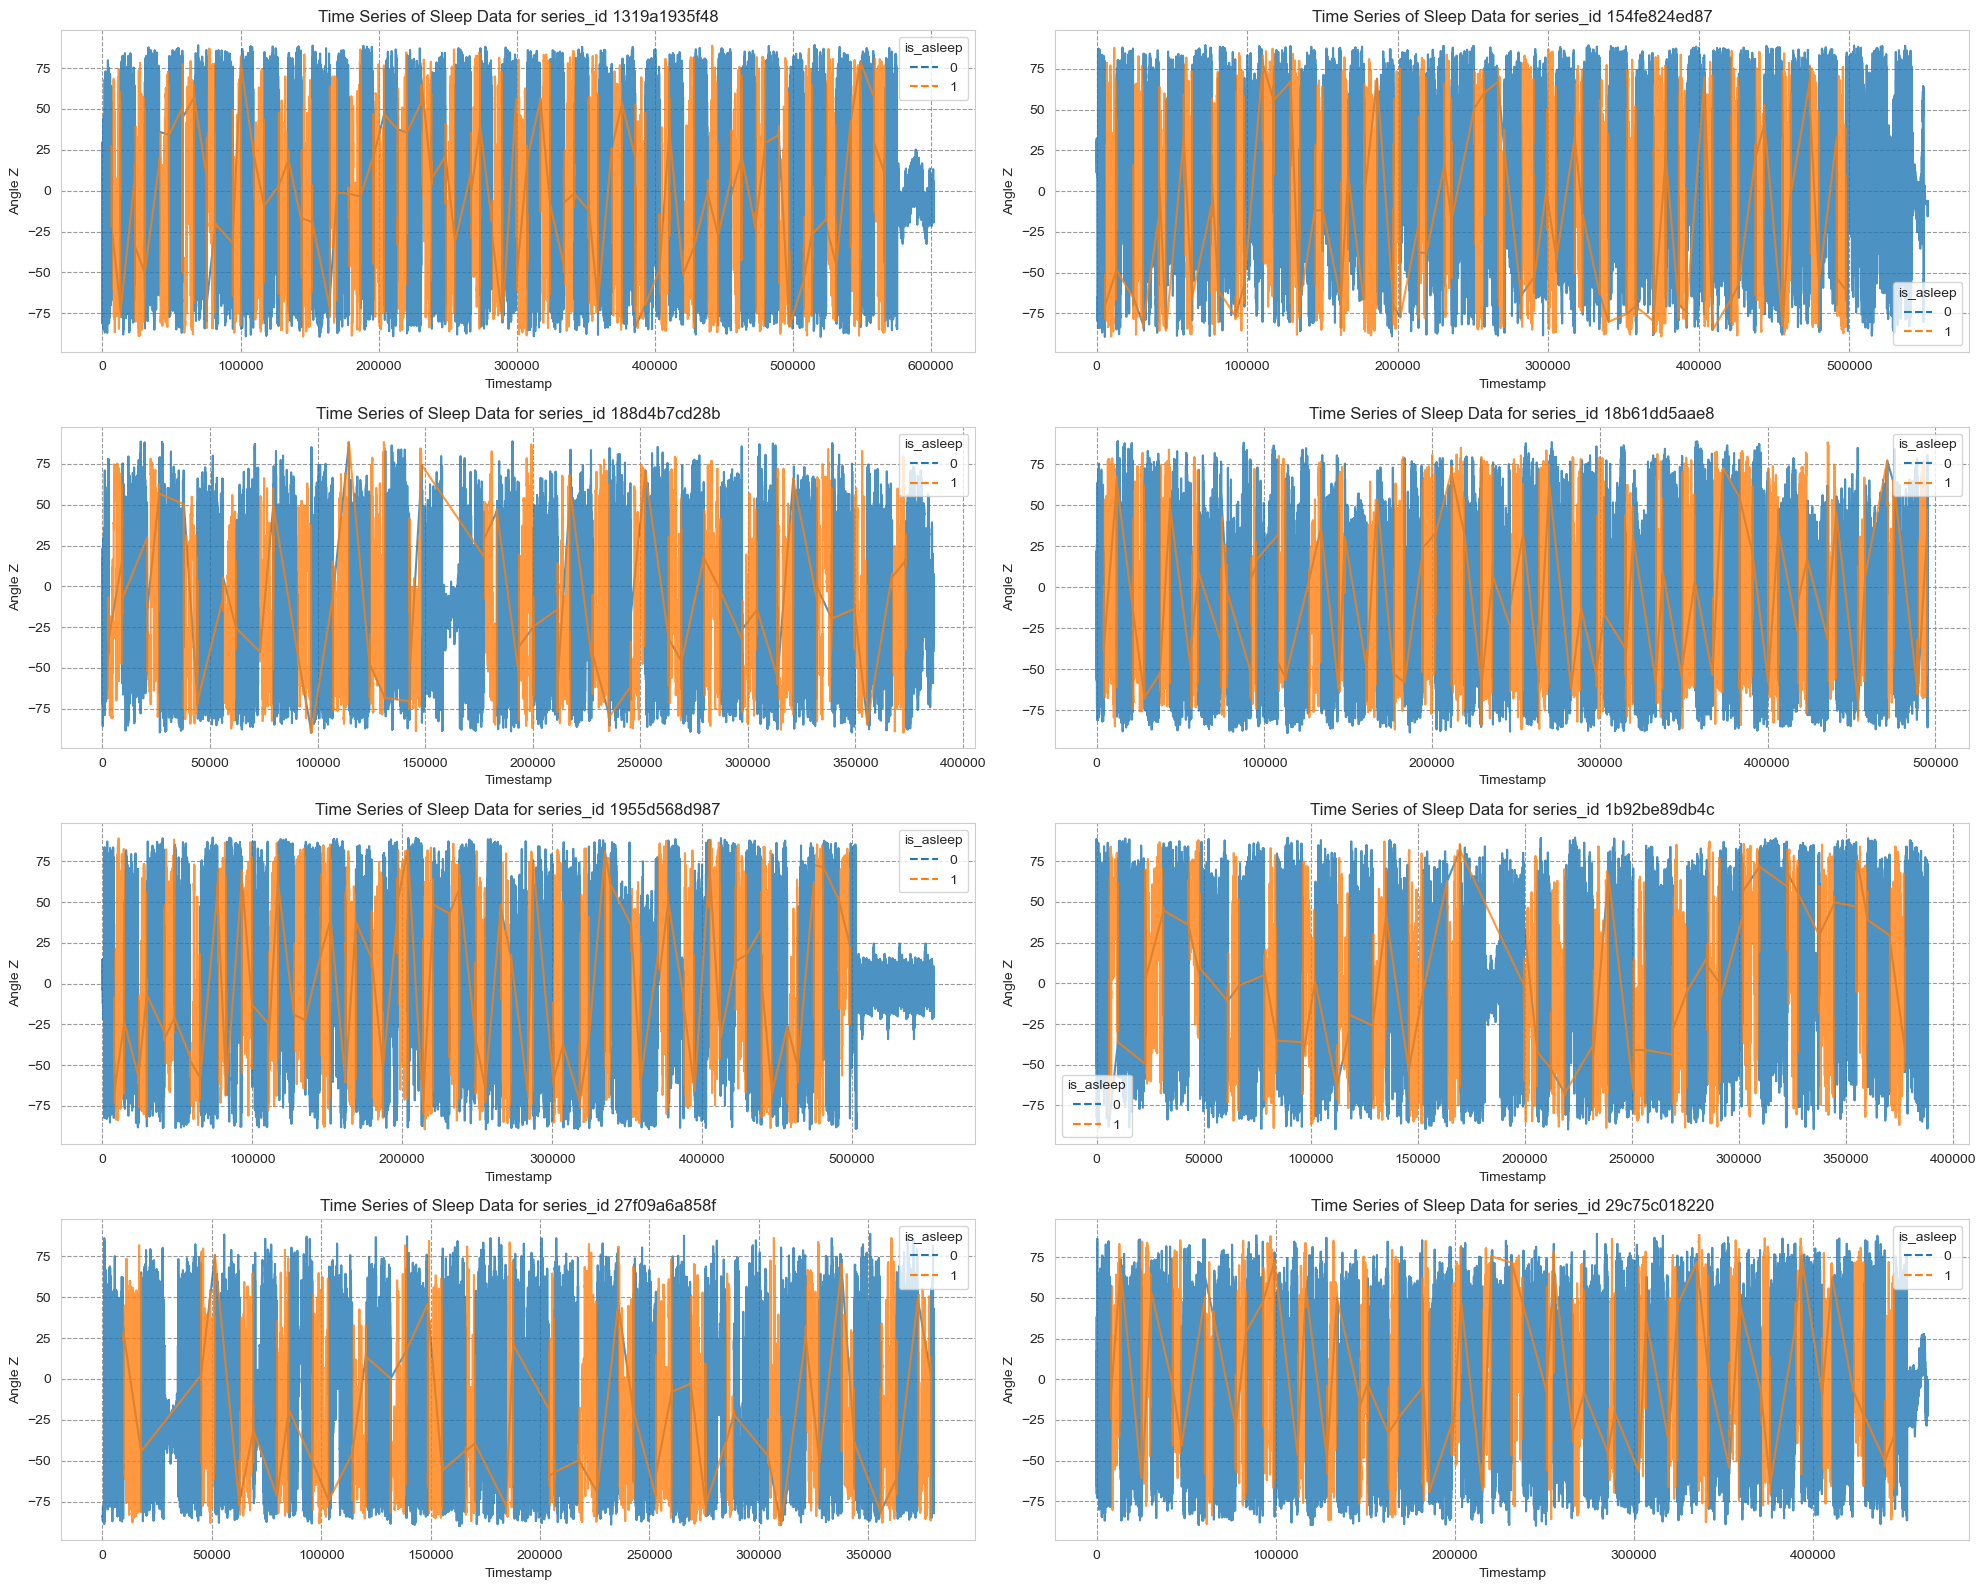

In [72]:
fig, axs = plt.subplots(4, 2, figsize=(20, 16))
axs = axs.flatten()

for i, series_id in enumerate(null_series_id[8:16]):
    # Filter the dataframe for the current series_id
    data = df3[df3['series_id'] == series_id]

    # Plot the data
    sns.lineplot(ax=axs[i], data=data, x='step', y='anglez', hue='is_asleep', alpha=0.8)

    # Customizing each subplot
    axs[i].set_title(f'Time Series of Sleep Data for series_id {series_id}')
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Angle Z')
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### So finally we come to conclusion that lots of missing data are continuous with low anglez, now let's examine elmo

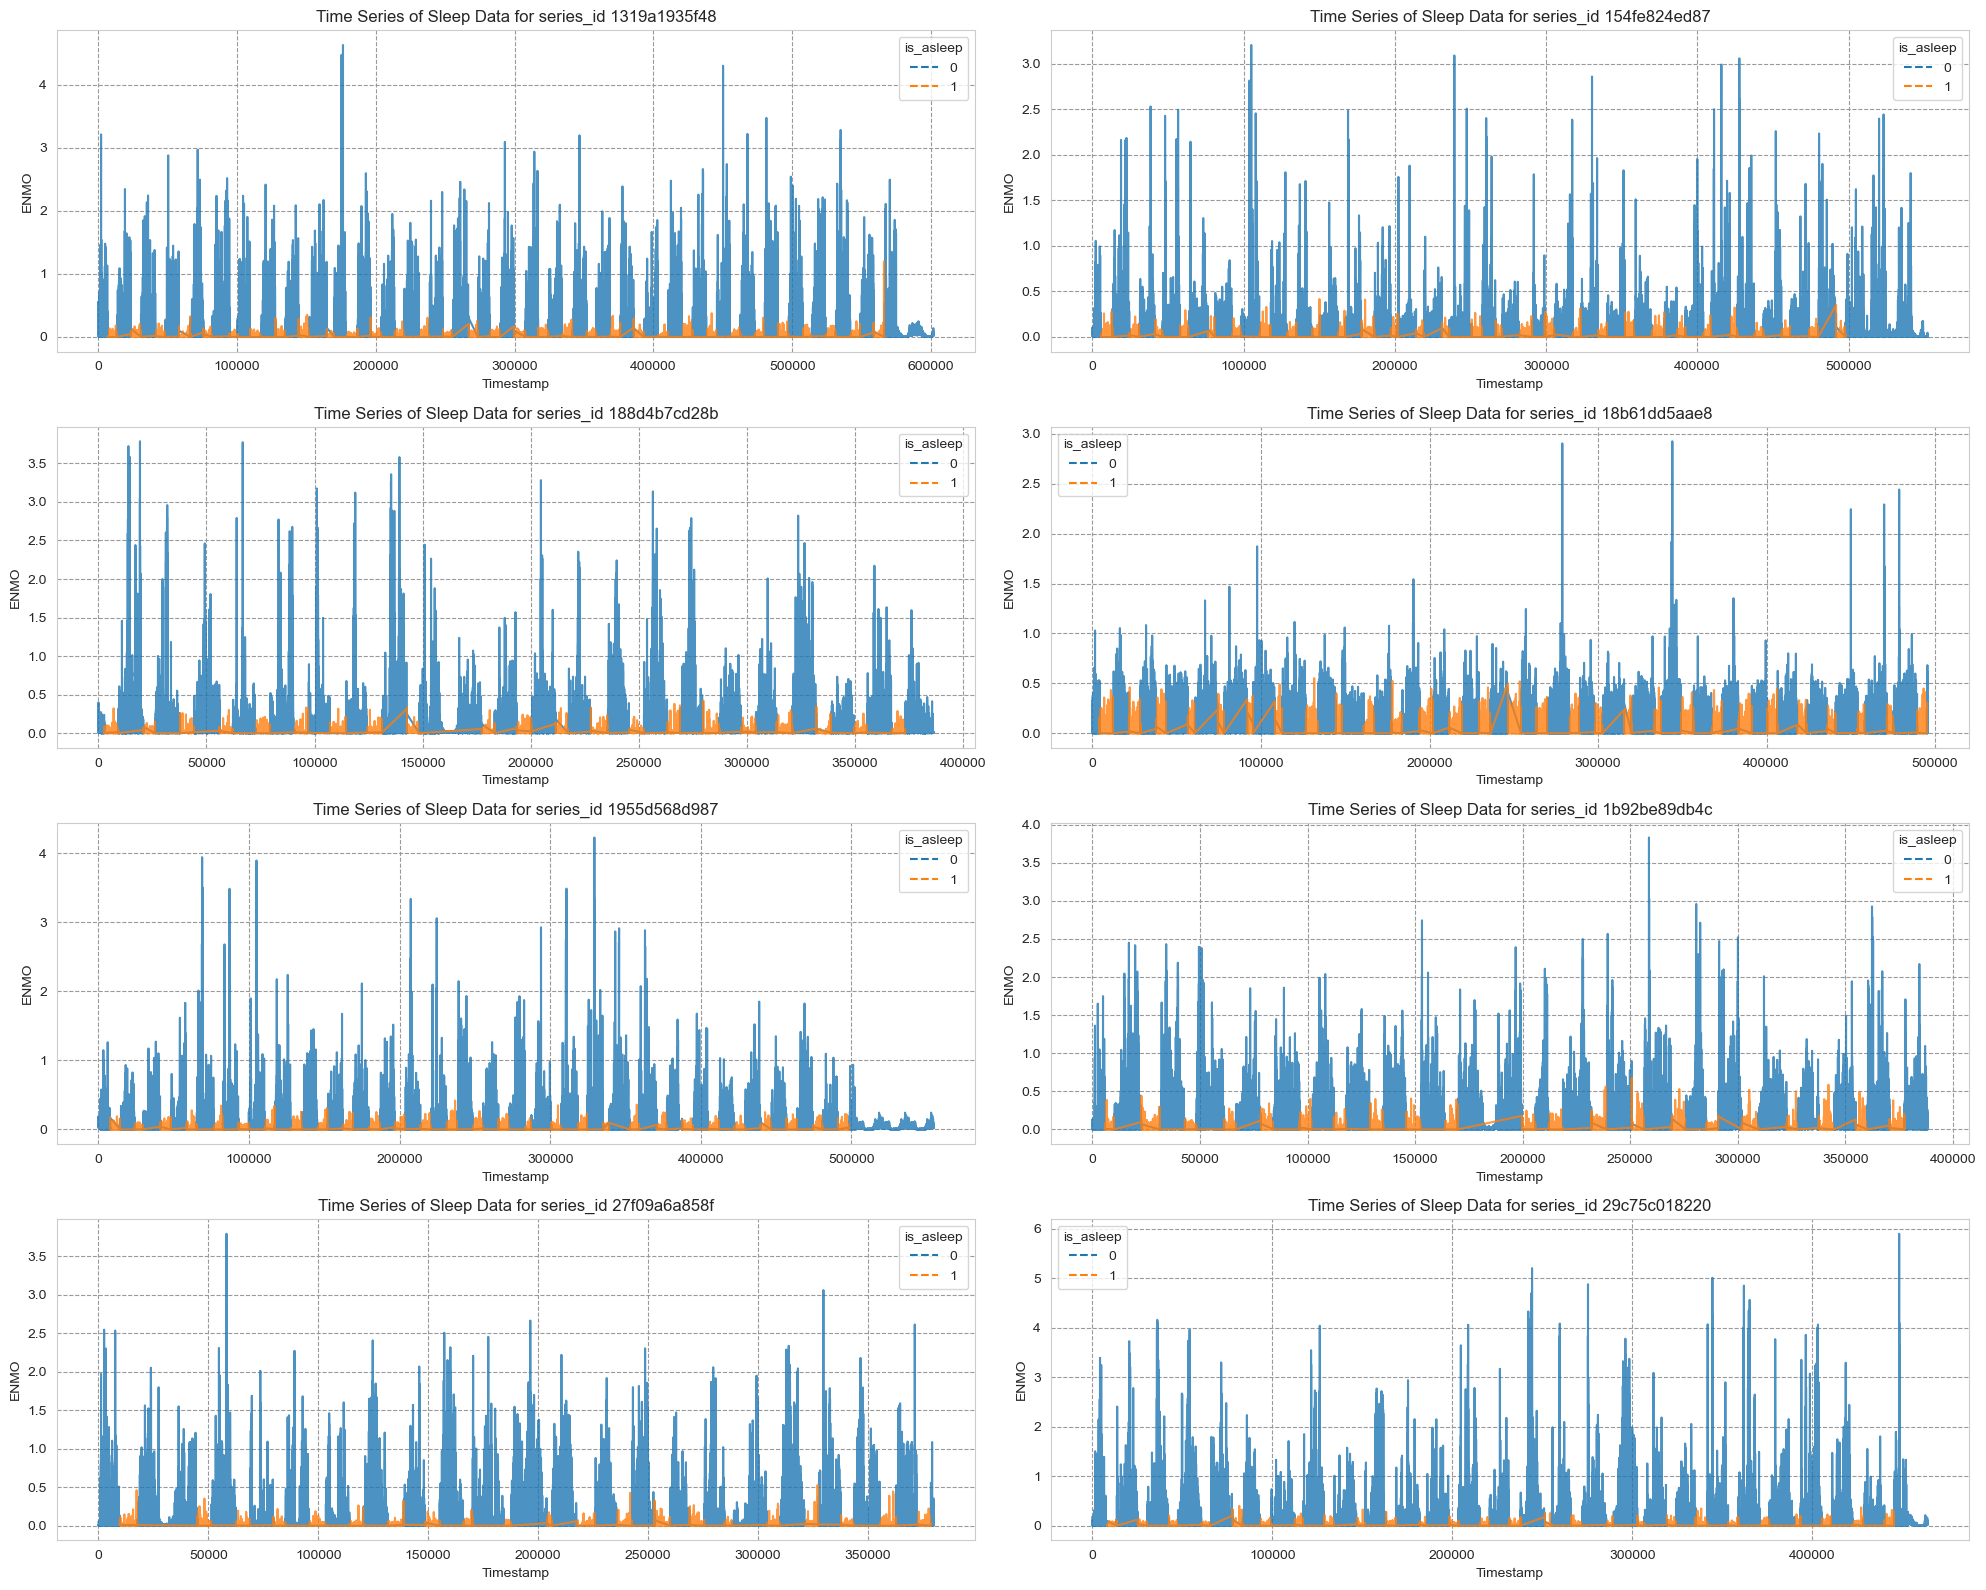

In [73]:
fig, axs = plt.subplots(4, 2, figsize=(20, 16))
axs = axs.flatten()

for i, series_id in enumerate(null_series_id[8:16]):
    # Filter the dataframe for the current series_id
    data = df3[df3['series_id'] == series_id]

    # Plot the data
    sns.lineplot(ax=axs[i], data=data, x='step', y='enmo', hue='is_asleep', alpha=0.8)

    # Customizing each subplot
    axs[i].set_title(f'Time Series of Sleep Data for series_id {series_id}')
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('ENMO')
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()